General Imports

In [37]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Samplers

In [38]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """ 
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
            - labels: shape (batch_size, label_dim)
        """
        pass


Sampling Allen Cahn

In [39]:
class AllenCahnInitialConditions(Sampleable):
    def __init__(self, N, domain_min=-1.0, domain_max=1.0):
        self.N = N
        self.x = torch.linspace(domain_min, domain_max, N)
        
    def sample(self, num_samples: int):
        # Create the specific initial condition: u(x,0) = sin(πx) * x² * (1-x)²
        # Note: The (1-x) term needs adjustment since domain is [-1,1]
        x = self.x
        u0 = torch.sin(torch.pi * x) * (x**2) * ((1 - x)**2)
        
        # Repeat for batch dimension
        u_batch = u0.unsqueeze(0).repeat(num_samples, 1)
        
        return u_batch, None

Gaussians

In [40]:
class GaussianInitialConditions(Sampleable):
    def __init__(self, N, domain_min=-1.0, domain_max=1.0,
                 num_gaussians=3,
                 amp_range=(0.5, 1.5),
                 width_range=(0.05, 0.3)):
        self.N = N
        self.x = torch.linspace(domain_min, domain_max, N)
        self.num_gaussians = num_gaussians
        self.amp_range = amp_range
        self.width_range = width_range

    def sample(self, num_samples: int):
        x = self.x.unsqueeze(0).repeat(num_samples, 1)  # (B, N)

        u_batch = torch.zeros(num_samples, self.N)

        for b in range(num_samples):
            u = torch.zeros(self.N)

            for _ in range(self.num_gaussians):
                # Random Gaussian parameters
                center = torch.empty(1).uniform_(self.x.min(), self.x.max()).item()
                amp = torch.empty(1).uniform_(*self.amp_range).item()
                width = torch.empty(1).uniform_(*self.width_range).item()

                u += amp * torch.exp(-(self.x - center)**2 / (2 * width**2))

            u_batch[b] = u

        return u_batch, None


Sines with different PIs

In [41]:
class SinePiAugmentedInitialConditions(Sampleable):
    def __init__(self, N, domain_min=-1.0, domain_max=1.0,
                 min_frac=0.0, max_frac=1.0):
        """
        min_frac, max_frac define α in sin((π + α·π) x)
        where α ∈ [min_frac, max_frac].
        """
        self.N = N
        self.x = torch.linspace(domain_min, domain_max, N)
        self.min_frac = min_frac
        self.max_frac = max_frac

    def sample(self, num_samples: int):
        u_batch = torch.zeros(num_samples, self.N)

        for b in range(num_samples):
            # Random fraction of π to add
            alpha = torch.empty(1).uniform_(self.min_frac, self.max_frac).item()
            freq = torch.pi * (1.0 + alpha)

            u0 = torch.sin(freq * self.x) * (self.x**2) * ((1 - self.x)**2)

            u_batch[b] = u0

        return u_batch, None


ODE and SDE

In [42]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - diffusion_coefficient: shape (bs, c, h, w)
        """
        pass

class AllenCahnODE(ODE):
    def __init__(self, model):
        self.model = model

    def drift_coefficient(self, u, t, **kwargs):
        return self.model(u)


Simulator

In [43]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates an ODE with a 1D time grid ts.
        Args:
            x: initial state, shape (batch, N)
            ts: 1D tensor of shape (nts,)
        Returns:
            xs: trajectory, shape (batch, nts, N)
        """
        assert ts.dim() == 1, "ts must be a 1D time grid"

        xs = [x.clone()]               # list of (batch, N)
        for i in range(len(ts) - 1):
            t = ts[i].expand(x.size(0), 1)     # shape (batch, 1)
            h = (ts[i+1] - ts[i]).expand_as(t) # shape (batch, 1)
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())

        return torch.stack(xs, dim=1)   # (batch, nts, N)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.ode.drift_coefficient(xt,t, **kwargs) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.sde.drift_coefficient(xt,t, **kwargs) * h + self.sde.diffusion_coefficient(xt,t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

In [44]:
def allen_cahn_drift(u, dx, eps):
    """
    Compute Allen-Cahn drift with Neumann boundary conditions: u_x(±1) = 0
    """
    # Interior points: central difference
    u_xx_interior = (torch.roll(u, -1) - 2*u + torch.roll(u, 1)) / (dx*dx)
    
    # Apply Neumann boundary conditions: u_x = 0 at boundaries
    u_xx = u_xx_interior.clone()
    
    # At left boundary (x=-1): use forward difference approximation
    # u_x = 0 implies u[0] = u[1] for discrete approximation
    u_xx[..., 0] = (2*u[..., 1] - 2*u[..., 0]) / (dx*dx)
    
    # At right boundary (x=1): use backward difference approximation  
    # u_x = 0 implies u[-1] = u[-2] for discrete approximation
    u_xx[..., -1] = (2*u[..., -2] - 2*u[..., -1]) / (dx*dx)
    
    reaction = -(1/eps**2) * (u**3 - u)
    return u_xx + reaction

Training the model

In [45]:
MiB = 1024 ** 2
N = 256


def model_size_b(model: nn.Module) -> int:
    """
    Returns model size in bytes. Based on https://discuss.pytorch.org/t/finding-model-size/130275/2
    Args:
    - model: self-explanatory
    Returns:
    - size: model size in bytes
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        
        self.model = model
        # In Trainer class __init__:
        self.N = N
        self.domain_min = -1.0
        self.domain_max = 1.0
        self.dx = (self.domain_max - self.domain_min) / (N - 1)  # Adjust dx for domain
        self.eps = 0.01
        self.batch_size = 32  # Can be smaller since we have fixed IC

        # Use the new initial condition sampler
        self.initial_condition_sampler = SinePiAugmentedInitialConditions(
            N, self.domain_min, self.domain_max
        )


    def get_train_loss(self):

        # Sample batch of initial conditions
        u, _ = self.initial_condition_sampler.sample(self.batch_size)
        u = u.to(self.device)

        # True PDE drift
        target = allen_cahn_drift(u, self.dx, self.eps)

        # Predicted drift
        pred = self.model(u)

        # MSE loss
        return ((pred - target)**2).mean()

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Report model size

        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')
        self.device = device
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

        # Finish
        self.model.eval()

Model Architecture

In [46]:
class DriftModel1D(nn.Module):
    def __init__(self, N, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, N),
        )
    def forward(self, u):
        return self.net(u)

Training

In [47]:
model = DriftModel1D(N)
trainer = Trainer(model)

num_epochs = 2000
trainer.train(num_epochs=num_epochs, device=device, lr=1e-3)


Training model with size: 0.314 MiB


Epoch 1999, loss: 1633810944.000: : 2000it [00:11, 177.55it/s]


Evaluating

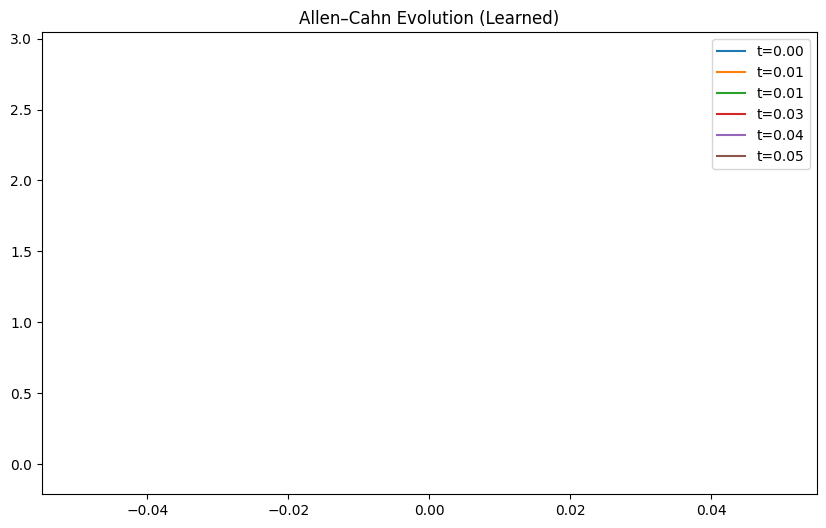

In [48]:
# Simulate PDE using learned model
ode = AllenCahnODE(model)
sim = EulerSimulator(ode)

# sample a single initial condition
u0, _ = trainer.initial_condition_sampler.sample(1)
u0 = u0[0].to(trainer.device)

# For evaluation - use your specified time domain
ts = torch.linspace(0, 0.05, 200)  # t ∈ [0, 0.05]

trajectory = sim.simulate_with_trajectory(u0.unsqueeze(0), ts)[0]
trajectory = trajectory[0]  # remove batch dimension

# Plot solution evolution
plt.figure(figsize=(10,6))
for i in [0, 20, 50, 100, 150, 199]:
    plt.plot(trajectory[i], label=f"t={float(ts[i]):.2f}")
plt.legend()
plt.title("Allen–Cahn Evolution (Learned)")
plt.show()


FINITE DIFFERENCE

In [50]:
def solve_allen_cahn_fd(u0, ts, dx, eps):
    """
    Classical finite-difference time stepping for Allen–Cahn.
    Explicit Euler.
    u0: (N,)
    ts: (T,)
    returns: trajectory (T, N)
    """
    u = u0.clone()
    traj = [u.clone()]

    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        drift = allen_cahn_drift(u.unsqueeze(0), dx, eps)[0]
        u = u + dt * drift
        traj.append(u.clone())

    return torch.stack(traj, dim=0)


FINAL PLOT

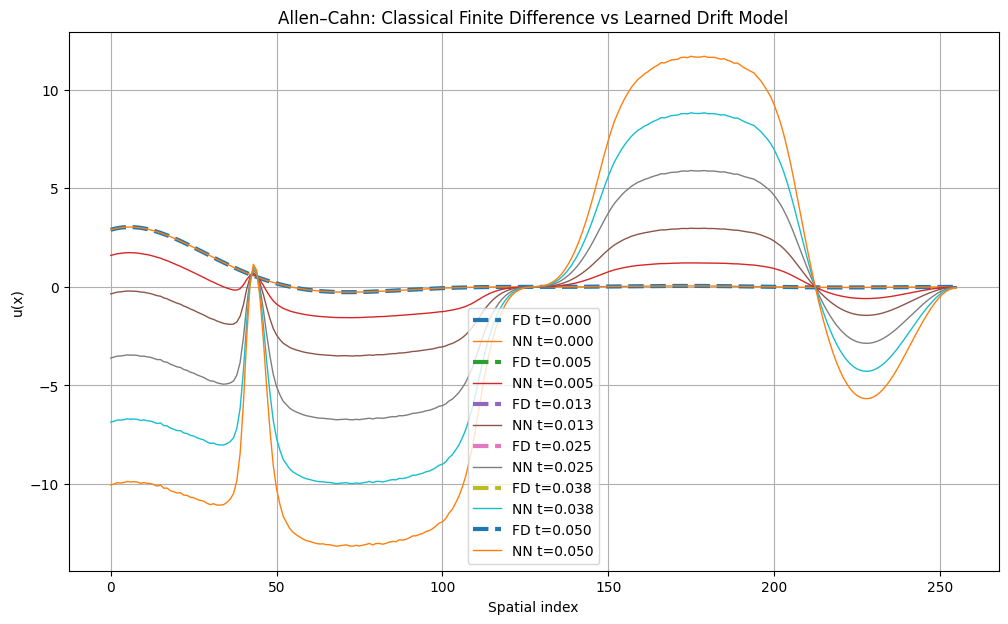

In [52]:
# Finite-difference solution
traj_fd = solve_allen_cahn_fd(u0, ts, trainer.dx, trainer.eps)

# Learned model solution
traj_learned = sim.simulate_with_trajectory(u0.unsqueeze(0), ts)[0]

# Indices to plot
idxs = [0, 20, 50, 100, 150, 199]

plt.figure(figsize=(12, 7))

for i in idxs:
    plt.plot(traj_fd[i], '--', label=f"FD t={float(ts[i]):.3f}", linewidth=3)
    plt.plot(traj_learned[i], label=f"NN t={float(ts[i]):.3f}", linewidth=1)

plt.title("Allen–Cahn: Classical Finite Difference vs Learned Drift Model")
plt.xlabel("Spatial index")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.show()
